In [2]:
import pandas as pd
import datetime
from simpledbf import Dbf5

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [8]:
########## INPUT ##############

In [36]:
unf_path= r"C:\Users\Simon\Analysen\Unfaelle\unfaelle_wetter\Unflle2015_2016_Geo_bw.xlsx"

unf=  pd.read_excel(unf_bw_path,skiprows=3, index_col=0,sheet_name='2016') 
unf=unf_bw.reset_index()

In [37]:
#baue time string
unf['UNFZEIT']= "20" + unf.Jahr.astype(str) + ("00" + unf.Monat.astype(str)).str[-2:]+ ("00" + unf.Tag.astype(str)).str[-2:]+ ("00" + unf.Stunde.astype(str)).str[-2:]

#als datetime object
unf['UNFZEIT'] = pd.to_datetime(unf['UNFZEIT'], format = '%Y%m%d%H')

In [30]:
#Wetter Stuttgart
temp_path = r"C:\Users\Simon\Analysen\Unfaelle\unfaelle_wetter\stundenwerte_TU_04931_hist\produkt_tu_stunde_19530101_20181231_04931.txt"

temp = pd.read_csv(temp_path, sep=";", low_memory=False)

#als datetime object
temp.MESS_DATUM = pd.to_datetime(temp.MESS_DATUM, format = '%Y%m%d%H')

# runde Temperatur
temp.TT_TU = temp.TT_TU.round(0)

# filtere auf das Jahr 2016 
temp = temp[(temp.MESS_DATUM>pd.Timestamp(datetime.date(2016,1,1))) & 
                         (temp.MESS_DATUM<pd.Timestamp(datetime.date(2017,1,1)))].copy() 

In [11]:
#BAB und Bstr NRW
#Quelle: #https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Stundenwerte.html?nn=1817946

In [60]:
bast_path= r"C:\Users\Simon\Analysen\Bast_stundendaten\bast_ab_bw.csv"
bast= pd.read_csv(bast_path, sep=";", low_memory=False)

# time cleaner
bast.Stunde =bast.Stunde.replace(24,0)
                                 
bast['datetime']= "20" + bast.Datum.astype(str) + ("00" + bast.Stunde.astype(str)).str[-2:]

bast['datetime'] = pd.to_datetime(bast['datetime'], format = '%Y%m%d%H')

# sum counts
bast['KFZ_querschnitt']=bast.KFZ_R1 +bast.KFZ_R2

# anzahl der zaelstellen in nrw
len(bast.Zst.unique())

67

In [61]:
############## TIME FILTER   ###################

In [62]:
timerange= [6,22]

In [63]:
# time filter
bast = bast[(bast.datetime.dt.hour>=timerange[0]) & 
            (bast.datetime.dt.hour<=timerange[1])].copy()  

In [64]:
# time filter
temp = temp[(temp.MESS_DATUM.dt.hour>=timerange[0]) & 
            (temp.MESS_DATUM.dt.hour<=timerange[1])].copy()  

In [65]:

# time filter
unf = unf[(unf.UNFZEIT.dt.hour>=timerange[0]) & 
         (unf.UNFZEIT.dt.hour<=timerange[1])].copy()  

In [66]:
##################### MERGES - > Häufigkeiten #########################

In [67]:
##### UNFALL und TEMPERATUR

In [68]:
merge = unf.merge(temp_nrw[['MESS_DATUM','TT_TU']], how='left', left_on='UNFZEIT', right_on='MESS_DATUM')

In [69]:
# haefigkeit unfealle nach temp
merge.TT_TU.value_counts().head()

4.0     2238
16.0    2152
6.0     2049
2.0     1974
14.0    1891
Name: TT_TU, dtype: int64

In [70]:
merge_2016_hist = merge.TT_TU.value_counts().reset_index()
merge_2016_hist = merge_2016_hist.rename(columns={'index': 'temp', 'TT_TU': 'count'})

In [71]:
merge_2016_hist['rel']= merge_2016_hist['count']/merge_2016_hist['count'].sum()

In [72]:
merge_2016_hist['label']=merge_2016_hist['count']

In [73]:
##### Stunden und TEMPERATUR

In [74]:
temp.TT_TU.value_counts().head()

4.0    348
6.0    326
2.0    308
7.0    288
5.0    272
Name: TT_TU, dtype: int64

In [75]:
temp_hist = temp.TT_TU.value_counts().reset_index()
temp_hist = temp_hist.rename(columns={'index': 'temp', 'TT_TU': 'count'})

In [76]:
temp_hist['rel']= temp_hist['count']/temp_hist['count'].sum()

In [77]:
temp_hist['label']=temp_hist['count']


In [79]:
##### BAST und TEMPERATUR
merge_kfz_temp = bast.merge(temp[['MESS_DATUM','TT_TU']], how='left', left_on='datetime', right_on='MESS_DATUM')

In [80]:
### group by count and temp
merge_kfz_temp_hist = merge_kfz_temp.groupby('TT_TU')['KFZ_querschnitt'].agg(['size', 'mean'])

In [81]:
merge_kfz_temp_hist =merge_kfz_temp_hist.reset_index()

merge_kfz_temp_hist = merge_kfz_temp_hist.rename(columns={'mean': 'count', 'TT_TU': 'temp'})

In [82]:
merge_kfz_temp_hist.head()

,temp,size,count
0,-10.0,335,1259.122388
1,-9.0,402,1934.059701
2,-8.0,603,1327.814262
3,-7.0,335,2284.707463
4,-6.0,938,1200.609808


In [83]:
merge_kfz_temp_hist['rel']= (merge_kfz_temp_hist['count']*merge_kfz_temp_hist['size'])/(merge_kfz_temp_hist['count']*merge_kfz_temp_hist['size']).sum()

In [84]:
merge_kfz_temp_hist['label']= (merge_kfz_temp_hist['count']*merge_kfz_temp_hist['size'])

In [85]:
merge_kfz_temp_hist.head()

,temp,size,count,rel,label
0,-10.0,335,1259.122388,0.000611,421806.0
1,-9.0,402,1934.059701,0.001126,777492.0
2,-8.0,603,1327.814262,0.001159,800672.0
3,-7.0,335,2284.707463,0.001108,765377.0
4,-6.0,938,1200.609808,0.001631,1126172.0


In [39]:
################  APPEND MERGED   ###################

In [86]:
temp_hist['cat']='#Stunden'

In [87]:
merge_2016_hist['cat']='#Unfälle'

In [88]:
merge_kfz_temp_hist['cat']='Verkehrsaufkommen'

In [89]:
both =temp_hist.append(merge_2016_hist)

In [90]:
all3 =merge_kfz_temp_hist.append(both)

C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [91]:
all3

,cat,count,label,rel,size,temp
0,Verkehrsaufkommen,1259.122388,421806.0,0.000611,335.0,-10.0
1,Verkehrsaufkommen,1934.059701,777492.0,0.001126,402.0,-9.0
2,Verkehrsaufkommen,1327.814262,800672.0,0.001159,603.0,-8.0
3,Verkehrsaufkommen,2284.707463,765377.0,0.001108,335.0,-7.0
4,Verkehrsaufkommen,1200.609808,1126172.0,0.001631,938.0,-6.0
5,Verkehrsaufkommen,1210.918485,2109420.0,0.003054,1742.0,-5.0
6,Verkehrsaufkommen,1262.318599,4397918.0,0.006368,3484.0,-4.0
7,Verkehrsaufkommen,1527.136650,4604317.0,0.006667,3015.0,-3.0
8,Verkehrsaufkommen,1516.997668,6504886.0,0.009418,4288.0,-2.0
9,Verkehrsaufkommen,1558.958682,8564919.0,0.012401,5494.0,-1.0


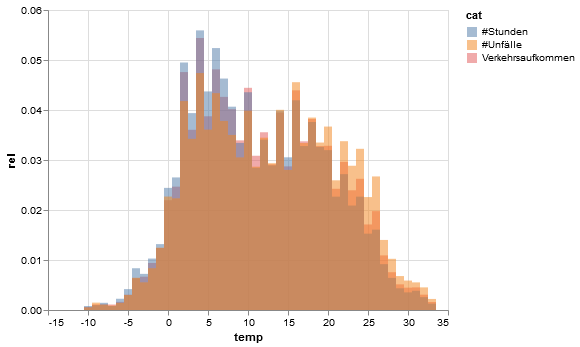

In [92]:
import altair as alt
alt.renderers.enable('notebook')



chart2= alt.Chart(all3).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color='cat'   
)

chart2

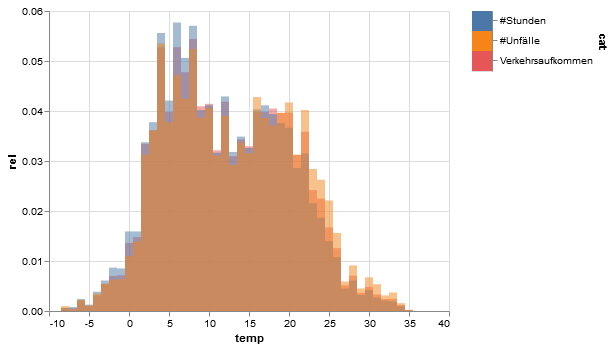

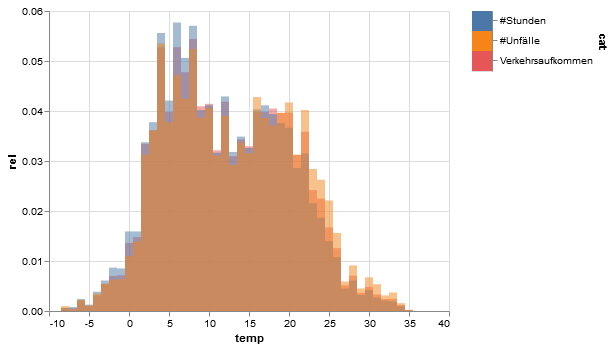

In [80]:
import altair as alt

selection = alt.selection_multi(fields=['cat'])
color = alt.condition(selection, alt.Color('cat:N', legend=None), alt.value('transparent'))


chart= alt.Chart(all3).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None), 
    color=color
).add_selection(
    selection
)

legend = alt.Chart(all3).mark_rect().encode(
    y=alt.Y('cat:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

chart | legend

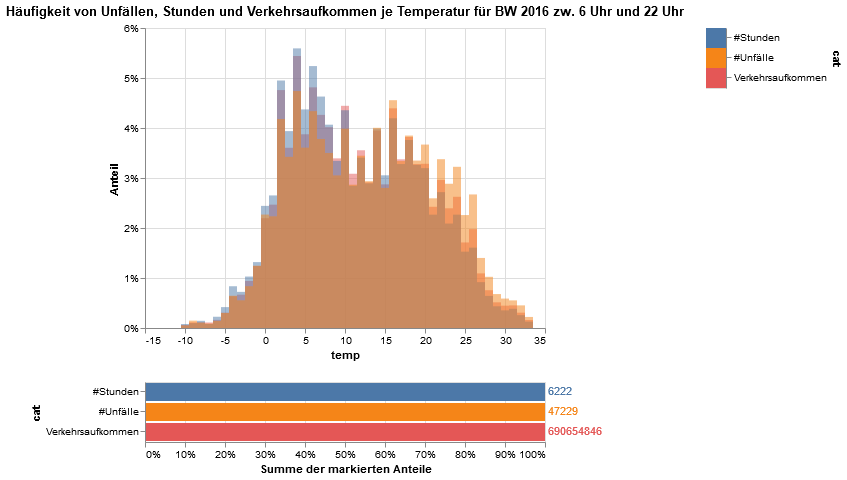

In [95]:
import altair as alt



data_source=all3

selection = alt.selection_multi(fields=['cat'])
color = alt.condition(selection, alt.Color('cat:N', legend=None), alt.value('transparent'))






brush = alt.selection(type='interval', encodings=["x"])

title='Häufigkeit von Unfällen, Stunden und Verkehrsaufkommen je Temperatur für BW 2016 zw. 6 Uhr und 22 Uhr'


chart= alt.Chart(data_source,title=title).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y= alt.Y('rel', axis=alt.Axis(format='%', title='Anteil')),#,alt.Y('rel', stack=None), 
    color=color,
    #tooltip='label'
).add_selection(
    brush
).add_selection(
    selection
)

legend = alt.Chart(data_source).mark_rect().encode(
    y=alt.Y('cat:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)




bars = alt.Chart(data_source).mark_bar().encode(
    y='cat:N',
    color=color,
    x=alt.X('sum(rel):Q', axis=alt.Axis(format='%', title='Summe der markierten Anteile')) #'sum(rel):Q' 
).transform_filter(
    brush
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(label):N'
    #text= alt.condition(alt.datum.cat==alt.value('Verkehrsaufkommen'), 'sum(size):N', 'sum(count):N')
)



chrt= (chart  & (bars + text)) | legend

chrt

In [96]:
chrt.save('unfl_temp_bw.html')

In [106]:
from bs4 import BeautifulSoup
html = open("unfl_temp.html").read()
soup = BeautifulSoup(html)

sources = ['https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Stundenwerte.html?nn=1817946',
           'blabla',
           'https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivstunden.html'
    
]

for i in sources:
    new_div = soup.new_tag('div')
    new_div.string=i
    soup.html.append(new_div)

with open("unfl_temp_bs4.html", "w") as file:
    file.write(str(soup))

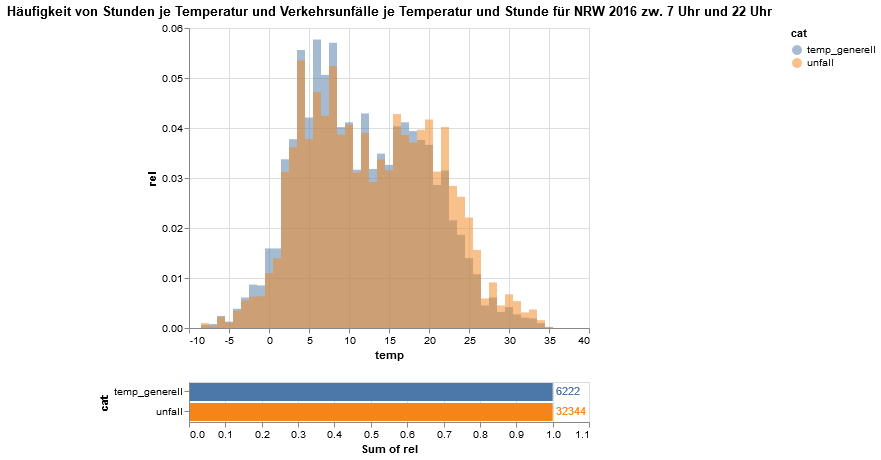

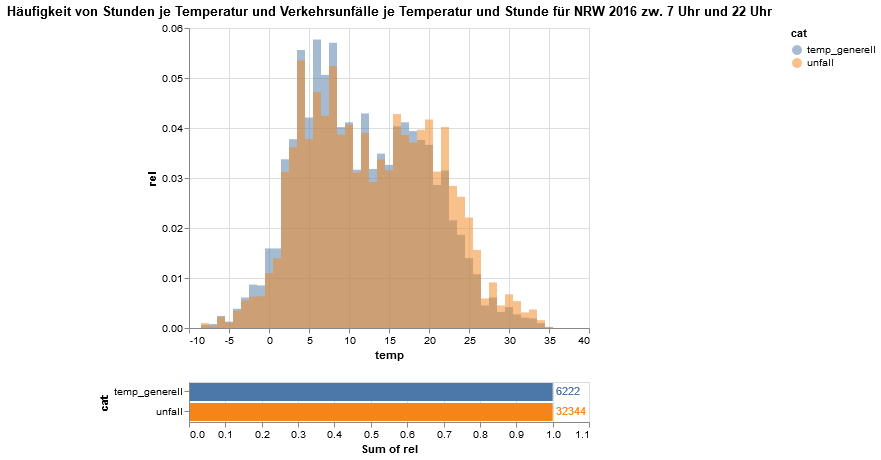

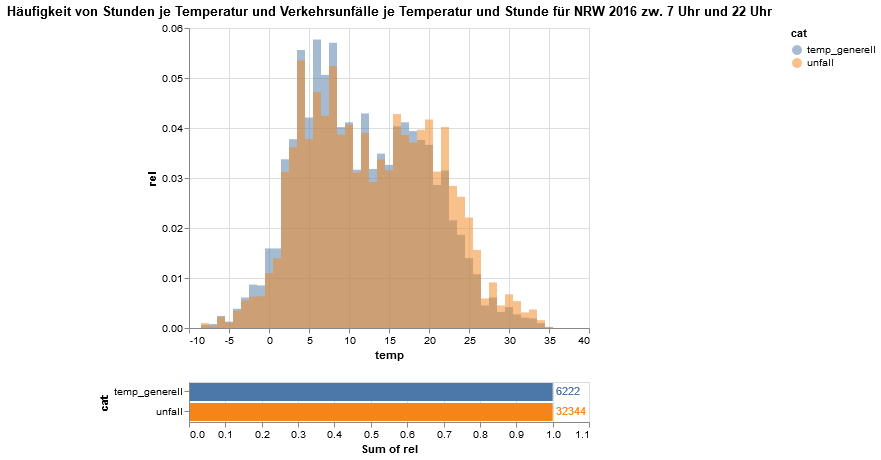

In [246]:
import altair as alt


brush = alt.selection(type='interval', encodings=["x"])

title='Häufigkeit von Stunden je Temperatur und Verkehrsunfälle je Temperatur und Stunde für NRW 2016 zw. 7 Uhr und 22 Uhr'

chart2= alt.Chart(both,title=title).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color=alt.condition(brush, 'cat:N', alt.value('lightgray')) 
).add_selection(
    brush
)



bars = alt.Chart(both).mark_bar().encode(
    y='cat:N',
    color='cat:N',
    x='sum(rel):Q'
).transform_filter(
    brush
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(count):N'
)




chrt= chart2 & (bars + text) 

chrt

In [114]:
chrt.save('unfl_temp.html')

In [128]:
from bs4 import BeautifulSoup
html = open("unfl_temp.html").read()
soup = BeautifulSoup(html)
new_div = soup.new_tag('div')
new_div.string="abcdef"
soup.html.append(new_div)

with open("unfl_temp_bs4.html", "w") as file:
    file.write(str(soup))

In [ ]:
################# BAST ###################

In [ ]:
#https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Stundenwerte.html?nn=1817946

In [133]:
bast_path= r"C:\Users\Simon\Analysen\Bast_stundendaten\2016_a_b_NRW.csv"

In [134]:
bast= pd.read_csv(bast_path, sep=";", low_memory=False)

In [131]:
bast.head()

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
0,5308,5013,5,A,565,160101,5,s,1,90,...,0,-,1,-,0,-,0,-,0,-
1,5308,5013,5,A,565,160101,5,s,2,231,...,0,-,1,-,1,-,1,-,0,-
2,5308,5013,5,A,565,160101,5,s,3,223,...,0,-,1,-,0,-,0,-,0,-
3,5308,5013,5,A,565,160101,5,s,4,134,...,0,-,1,-,1,-,1,-,0,-
4,5308,5013,5,A,565,160101,5,s,5,68,...,0,-,1,-,1,-,0,-,0,-


In [152]:
bast_tester=bast[:10].copy()

In [172]:
bast.Stunde =bast.Stunde.replace(24,0)

In [173]:
bast['datetime']= "20" + bast.Datum.astype(str) + ("00" + bast.Stunde.astype(str)).str[-2:]


In [175]:
bast['datetime'] = pd.to_datetime(bast['datetime'], format = '%Y%m%d%H')

In [176]:
# time filter
bast = bast[(bast.datetime.dt.hour>=6) & 
            (bast.datetime.dt.hour<=22)].copy()  

In [181]:
bast['KFZ_querschnitt']=bast.KFZ_R1 +bast.KFZ_R2

In [188]:
#pd.set_option('display.max_columns', 15)

In [186]:
# anzahl der zaelstellen in nrw
len(bast.Zst.unique())

256

In [206]:
nrw_merge_kfz_temp = bast.merge(temp_nrw[['MESS_DATUM','TT_TU']], how='left', left_on='datetime', right_on='MESS_DATUM')

In [207]:
nrw_merge_kfz_temp.head()

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,...,K_Sat_R2,Son_R2,K_Son_R2,datetime,KFZ_querschnitt,MESS_DATUM,TT_TU
0,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 06:00:00,179,2016-01-01 06:00:00,3.7
1,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 07:00:00,141,2016-01-01 07:00:00,3.7
2,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 08:00:00,141,2016-01-01 08:00:00,3.9
3,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 09:00:00,150,2016-01-01 09:00:00,4.6
4,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 10:00:00,234,2016-01-01 10:00:00,5.5


In [208]:
nrw_merge_kfz_temp.TT_TU = nrw_merge_kfz_temp.TT_TU.round(0)

In [ ]:
### group by count and temp

In [216]:
#nrw_merge_kfz_temp.groupby(['TT_TU'])['KFZ_querschnitt'].mean()

In [238]:
nrw_merge_kfz_temp_hist = nrw_merge_kfz_temp.groupby('TT_TU')['KFZ_querschnitt'].agg(['size', 'mean'])

In [239]:
nrw_merge_kfz_temp_hist =nrw_merge_kfz_temp_hist.reset_index()

nrw_merge_kfz_temp_hist = nrw_merge_kfz_temp_hist.rename(columns={'mean': 'count', 'TT_TU': 'temp'})

In [240]:
nrw_merge_kfz_temp_hist

,temp,size,count
0,-8.0,1024,2350.982422
1,-7.0,1280,1703.121094
2,-6.0,3840,2186.040104
3,-5.0,2048,1956.430664
4,-4.0,6144,2037.200846
5,-3.0,9728,2222.181332
6,-2.0,13824,2017.392940
7,-1.0,13568,2097.424971
8,0.0,25344,2134.680240
9,1.0,25344,2321.572206


In [261]:
nrw_merge_kfz_temp_hist['rel']= (nrw_merge_kfz_temp_hist['count']*nrw_merge_kfz_temp_hist['size'])/(nrw_merge_kfz_temp_hist['count']*nrw_merge_kfz_temp_hist['size']).sum()

In [262]:
nrw_merge_kfz_temp_hist

,temp,size,count,rel,cat
0,-8.0,1024,2350.982422,0.000605,zaehlungen
1,-7.0,1280,1703.121094,0.000548,zaehlungen
2,-6.0,3840,2186.040104,0.002110,zaehlungen
3,-5.0,2048,1956.430664,0.001007,zaehlungen
4,-4.0,6144,2037.200846,0.003146,zaehlungen
5,-3.0,9728,2222.181332,0.005434,zaehlungen
6,-2.0,13824,2017.392940,0.007010,zaehlungen
7,-1.0,13568,2097.424971,0.007154,zaehlungen
8,0.0,25344,2134.680240,0.013600,zaehlungen
9,1.0,25344,2321.572206,0.014790,zaehlungen


In [303]:

nrw_merge_kfz_temp_hist['cat']='Verkehrsaufkommen'

In [304]:
all3 =nrw_merge_kfz_temp_hist.append(both)

In [305]:
all3.cat.unique()

array(['Verkehrsaufkommen', '#Stunden', '#Unfälle'], dtype=object)

In [306]:
all3

,cat,count,rel,size,temp
0,Verkehrsaufkommen,2350.982422,0.000605,1024,-8.0
1,Verkehrsaufkommen,1703.121094,0.000548,1280,-7.0
2,Verkehrsaufkommen,2186.040104,0.002110,3840,-6.0
3,Verkehrsaufkommen,1956.430664,0.001007,2048,-5.0
4,Verkehrsaufkommen,2037.200846,0.003146,6144,-4.0
5,Verkehrsaufkommen,2222.181332,0.005434,9728,-3.0
6,Verkehrsaufkommen,2017.392940,0.007010,13824,-2.0
7,Verkehrsaufkommen,2097.424971,0.007154,13568,-1.0
8,Verkehrsaufkommen,2134.680240,0.013600,25344,0.0
9,Verkehrsaufkommen,2321.572206,0.014790,25344,1.0


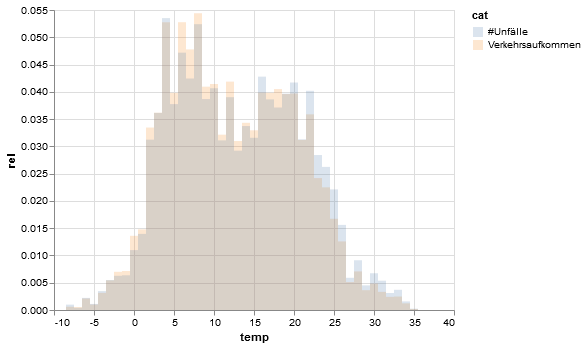

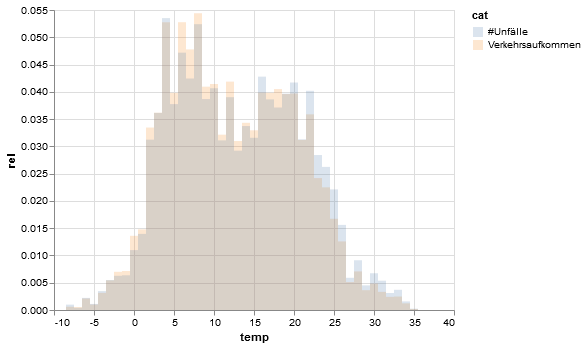

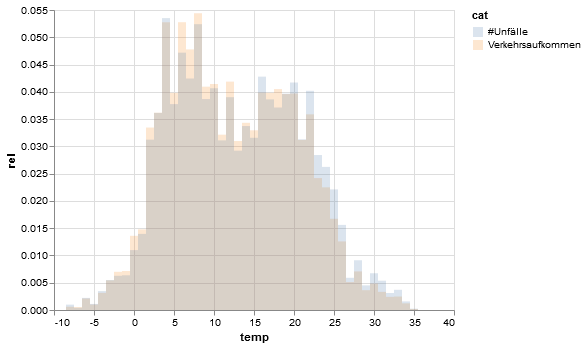

In [282]:
import altair as alt
alt.renderers.enable('notebook')



chart2= alt.Chart(all3[(all3.cat=='#Unfälle') | (all3.cat=='Verkehrsaufkommen')]).mark_bar(opacity=0.2,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color='cat'   
)

chart2

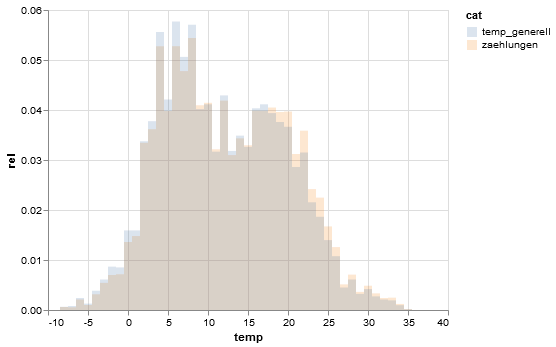

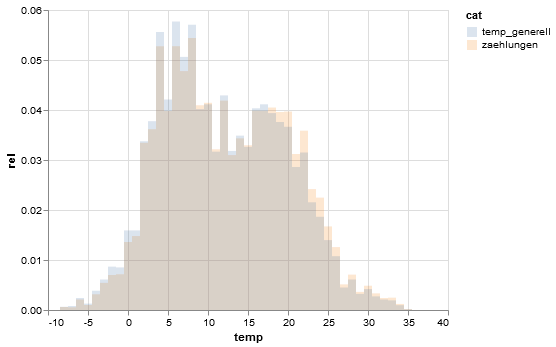

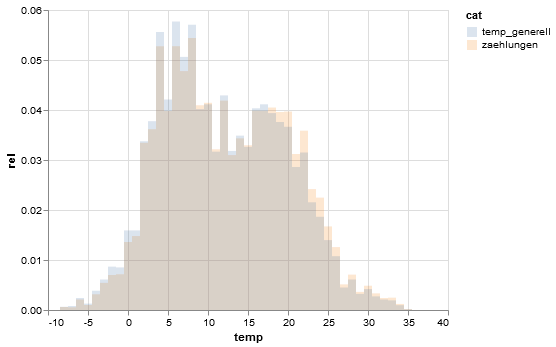

In [268]:
import altair as alt
alt.renderers.enable('notebook')



chart2= alt.Chart(all3[(all3.cat=='temp_generell') | (all3.cat=='zaehlungen')]).mark_bar(opacity=0.2,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color='cat'   
)

chart2

In [307]:
all3

,cat,count,rel,size,temp
0,Verkehrsaufkommen,2350.982422,0.000605,1024,-8.0
1,Verkehrsaufkommen,1703.121094,0.000548,1280,-7.0
2,Verkehrsaufkommen,2186.040104,0.002110,3840,-6.0
3,Verkehrsaufkommen,1956.430664,0.001007,2048,-5.0
4,Verkehrsaufkommen,2037.200846,0.003146,6144,-4.0
5,Verkehrsaufkommen,2222.181332,0.005434,9728,-3.0
6,Verkehrsaufkommen,2017.392940,0.007010,13824,-2.0
7,Verkehrsaufkommen,2097.424971,0.007154,13568,-1.0
8,Verkehrsaufkommen,2134.680240,0.013600,25344,0.0
9,Verkehrsaufkommen,2321.572206,0.014790,25344,1.0


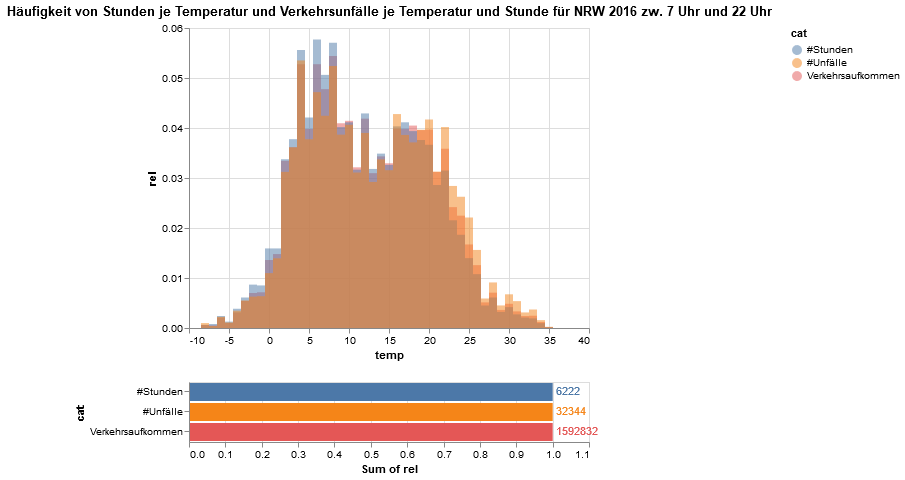

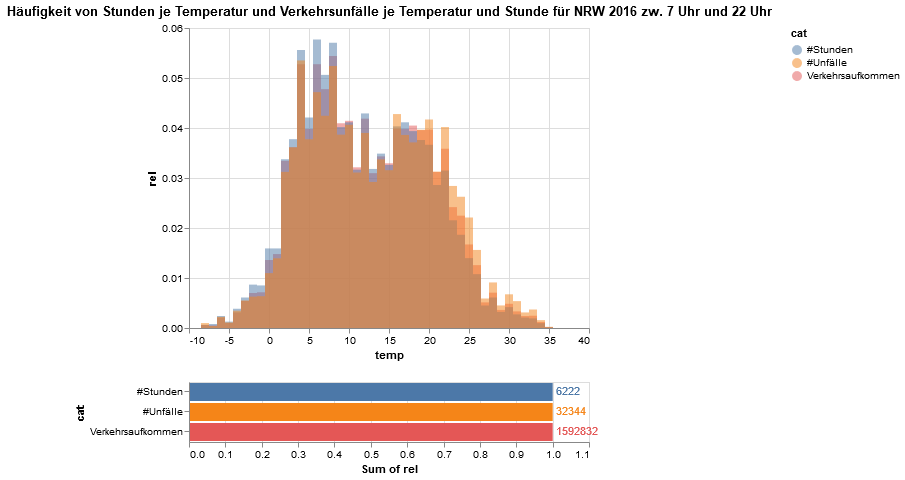

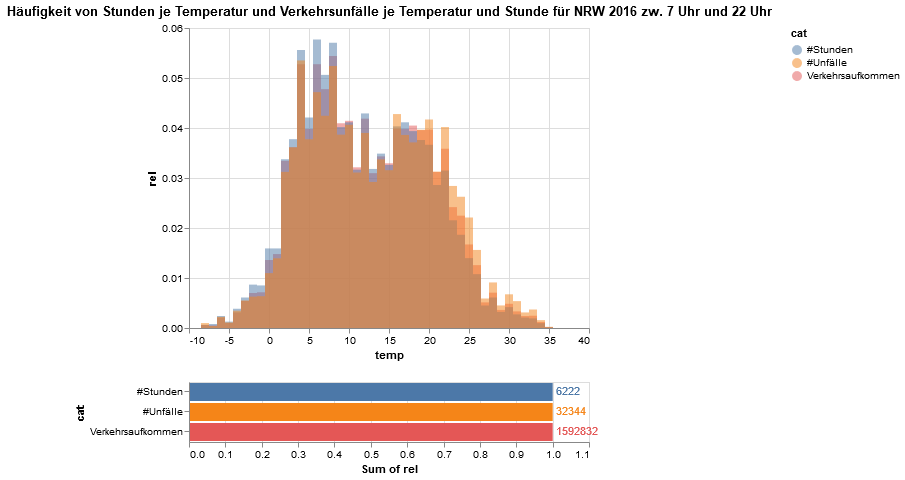

In [311]:
import altair as alt


brush = alt.selection(type='interval', encodings=["x"])

title='Häufigkeit von Stunden je Temperatur und Verkehrsunfälle je Temperatur und Stunde für NRW 2016 zw. 7 Uhr und 22 Uhr'

chart2= alt.Chart(all3,title=title).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color=alt.condition(brush, 'cat:N', alt.value('lightgray')) 
).add_selection(
    brush
)



bars = alt.Chart(all3).mark_bar().encode(
    y='cat:N',
    color='cat:N',
    x='sum(rel):Q'
).transform_filter(
    brush
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(size):N'
    #text= alt.condition(alt.datum.cat==alt.value('Verkehrsaufkommen'), 'sum(size):N', 'sum(count):N')
)

#    color=alt.condition(
 #       alt.datum.xval < selector.cutoff,
  #      alt.value('red'), alt.value('blue')
   # )


chrt= chart2 & (bars + text) 

chrt